     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 63.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 64.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 48.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.2-py3-none-any.whl size=25317058 sha256=9be62d66e197a1a138f99e01c8aaa98a0a8c4777f79b14045640

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Epoch 1/20
721/721 [==============================] - 1360s 2s/step - loss: 0.9707 - accuracy: 0.4872 - val_loss: 0.9117 - val_accuracy: 0.4861
Epoch 2/20
721/721 [==============================] - 1287s 2s/step - loss: 0.9075 - accuracy: 0.4941 - val_loss: 0.9232 - val_accuracy: 0.4845
Epoch 3/20
721/721 [==============================] - 1249s 2s/step - loss: 0.8641 - accuracy: 0.5368 - val_loss: 1.0386 - val_accuracy: 0.5250
Epoch 4/20
721/721 [==============================] - 1237s 2s/step - loss: 0.6879 - accuracy: 0.6644 - val_loss: 1.3627 - val_accuracy: 0.5405
Epoch 4: early stopping


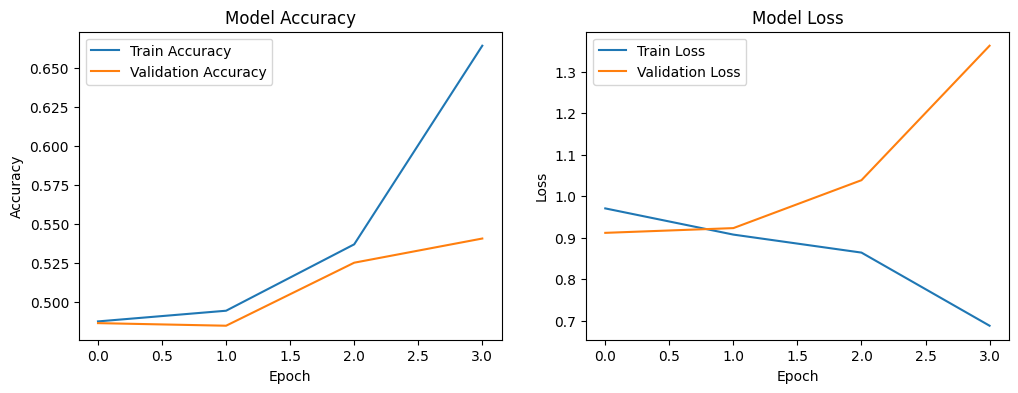

57/57 [==============================] - 11s 185ms/step
Test Loss: 0.8988886475563049
Test Accuracy: 50.55493712425232%

Classification Report:


ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [ ]:
# Required installations
!pip install nlpaug
!pip install ktrain

import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import Word
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential
from keras.layers import Embedding, Dropout, GRU, Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.utils import to_categorical
import nlpaug.augmenter.word as naw
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive')
path = 'drive/My Drive/Colab Notebooks/public-data/text_data'

# Downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Loading data
df = pd.read_csv(path+'/public_data.csv')
df['text'] = df['text'].fillna("")
df['label'] = df['label'].astype(int)


# Text preprocessing
df['lower_case'] = df['text'].apply(lambda x: x.lower().strip().replace('\n', ' ').replace('\r', ' '))
df['alphabatic'] = df['lower_case'].apply(lambda x: re.sub(r'[^a-zA-Z\']', ' ', x)).apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
df['without-link'] = df['alphabatic'].apply(lambda x: re.sub(r'http\S+', '', x))

tokenizer = RegexpTokenizer(r'\w+')
df['Special_word'] = df.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)
stop = [word for word in stopwords.words('english') if word not in ["my","haven't","aren't","can","no", "why", "through", "herself", "she", "he", "himself", "you", "you're", "myself", "not", "here", "some", "do", "does", "did", "will", "don't", "doesn't", "didn't", "won't", "should", "should've", "couldn't", "mightn't", "mustn't", "shouldn't", "hadn't", "wasn't", "wouldn't"]]
df['stop_words'] = df['Special_word'].apply(lambda x: [item for item in x if item not in stop])
df['stop_words'] = df['stop_words'].astype('str')
df['short_word'] = df['stop_words'].str.findall('\w{2,}')
df['string'] = df['short_word'].str.join(' ')
df['Text'] = df['string'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Dropping specific non-integer values and NaNs in 'label'
indexes_to_drop = df[df['label'].isin(['|', '11', '22', '32', '21'])].index
df.drop(indexes_to_drop, inplace=True)
df = df.dropna(subset=['label'])
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype('int32')

# Augmentation function
def augment_text(df, augmenter, repetitions=1):
    aug_texts = []
    for _, row in df.iterrows():
        text = row['text']
        for _ in range(repetitions):
            augmented_text = augmenter.augment(text)
            aug_texts.append((augmented_text, row['label']))
    return pd.DataFrame(aug_texts, columns=['text', 'label'])

# Synonym augmenter
augmenter = naw.SynonymAug(aug_src='wordnet')

# Upsampling using augmentation
max_size = df['label'].value_counts().max()
df_balanced = pd.DataFrame()
for label in df['label'].unique():
    df_class = df[df['label'] == label]
    df_class_aug = augment_text(df_class, augmenter, repetitions=max_size // len(df_class) - 1)
    df_balanced = pd.concat([df_balanced, df_class, df_class_aug])

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tokenization parameters
vocab_size = 20000
max_length = 300

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_val_padded = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length)
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)

# Convert labels to numpy arrays with int32 type
y_train_np = np.array(y_train).astype('int32')
y_val_np = np.array(y_val).astype('int32')
y_test_np = np.array(y_test).astype('int32')

# Model definition
model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    Dropout(0.5),
    GRU(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),
    GRU(50, dropout=0.5, recurrent_dropout=0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(df['label'].unique()), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


# Train the model with the validation set
history = model.fit(X_train_padded, y_train_np, epochs=20, batch_size=20, callbacks=[early_stopping], validation_data=(X_val_padded, y_val_np))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_np, verbose=False)
y_pred_proba = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100}%")




# ROC_AUC

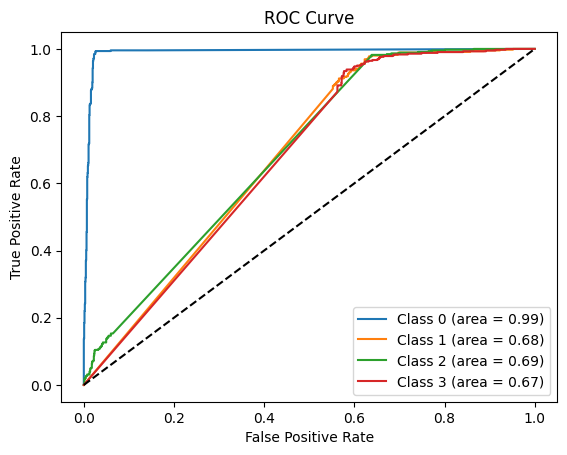

Average ROC-AUC: 0.7594694290881489


In [ ]:


# ROC-AUC Curve
y_test_cat = to_categorical(y_test, num_classes=len(df['label'].unique()))
roc_auc_scores = []
for i in range(len(df['label'].unique())):
    fpr, tpr, thresholds = roc_curve(y_test_cat[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores.append(roc_auc)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("Average ROC-AUC:", np.mean(roc_auc_scores))

# Confusion Matrix

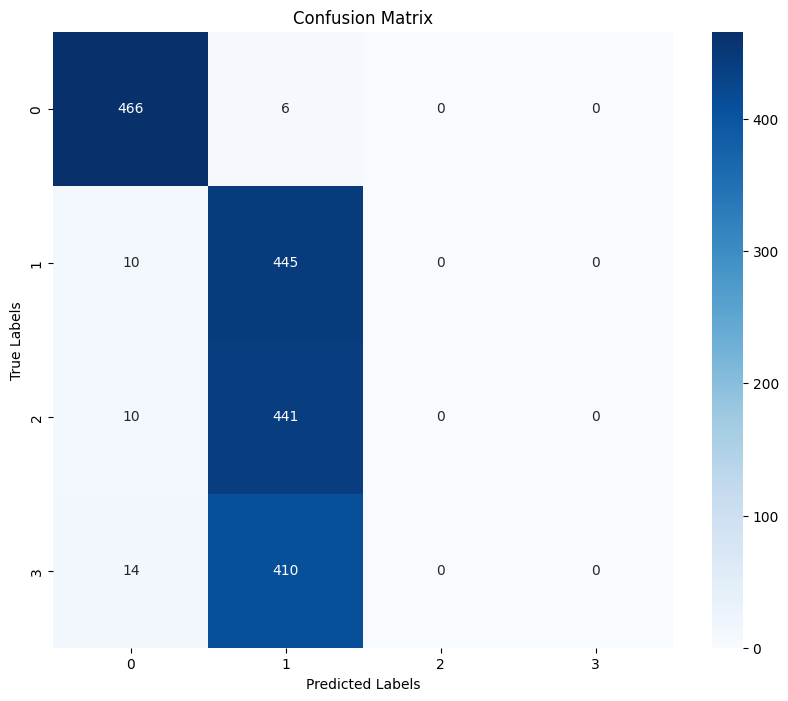

In [ ]:
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(df['label']), yticklabels=np.unique(df['label']))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# Result For four classes seperately

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       472
           1       0.34      0.98      0.51       455
           2       0.00      0.00      0.00       451
           3       0.00      0.00      0.00       424

    accuracy                           0.51      1802
   macro avg       0.32      0.49      0.37      1802
weighted avg       0.33      0.51      0.38      1802

Class-wise Accuracies:
Class 0 Accuracy: 98.73%
Class 1 Accuracy: 97.80%
Class 2 Accuracy: 0.00%
Class 3 Accuracy: 0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


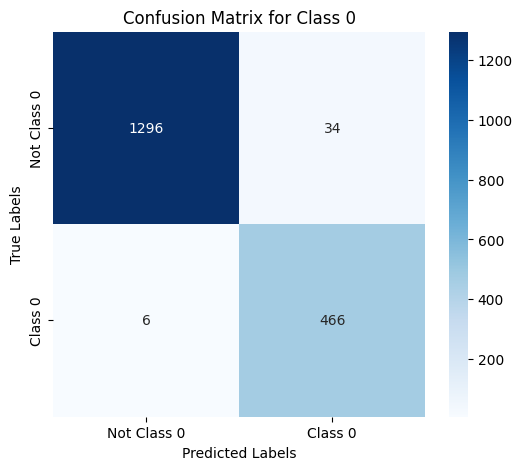

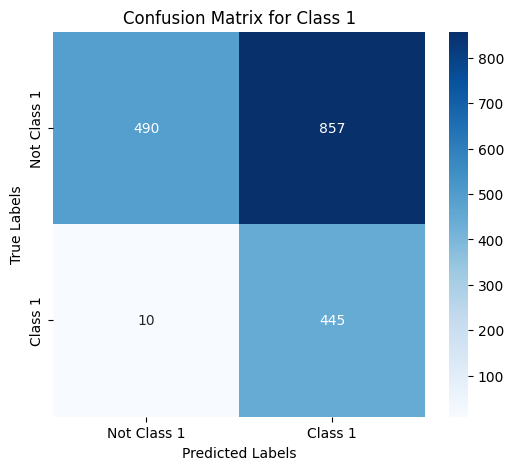

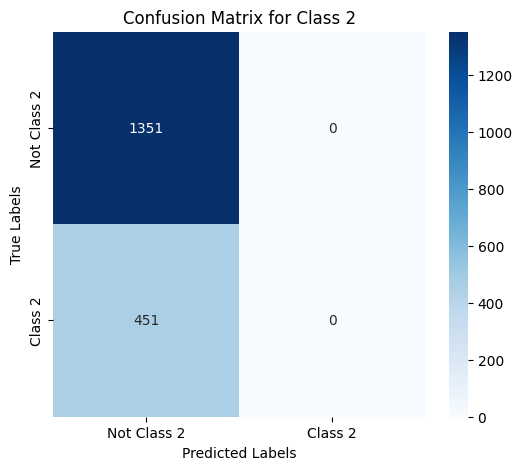

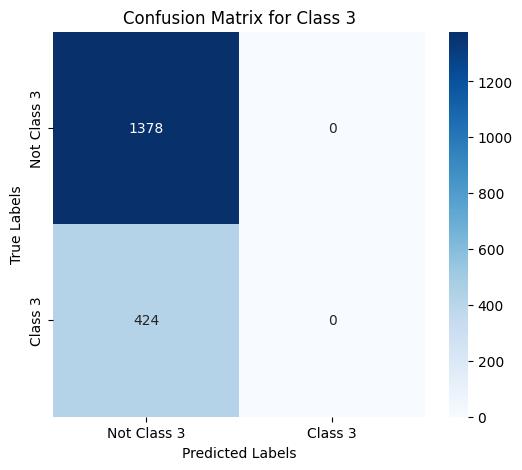

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Print classification report (includes precision, recall, F1 score for overall and each label )
print("Classification Report:")
print(classification_report(y_test_np, y_pred_classes, target_names=np.unique(df['label']).astype(str)))

# Calculating class-wise accuracy
class_accuracies = {}
unique_labels = np.unique(df['label'])
for label in unique_labels:
    class_mask = (y_test_np == label)
    class_acc = accuracy_score(y_test_np[class_mask], y_pred_classes[class_mask])
    class_accuracies[f"Class {label} Accuracy"] = class_acc

# Printing class-wise accuracies
print("Class-wise Accuracies:")
for class_label, acc in class_accuracies.items():
    print(f"{class_label}: {acc * 100:.2f}%")



import seaborn as sns

unique_labels = np.unique(df['label'])
for label in unique_labels:
    # Create a binary representation of y_test and y_pred for the current class
    y_test_binary = (y_test_np == label).astype(int)
    y_pred_binary = (y_pred_classes == label).astype(int)

    # Generate the confusion matrix for the current class
    conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

    # Plotting the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Class ' + str(label), 'Class ' + str(label)], yticklabels=['Not Class ' + str(label), 'Class ' + str(label)])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for Class {label}')
    plt.show()
